# Bibliotecas

In [1]:
import fbprophet
from fbprophet.diagnostics import cross_validation
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast
from statsforecast.models import MSTL
import utils.data_wrangling as dw
from utils.ts_wrangling import SerieTemporal, train_test_split
from utils.data_wrangling import prepare_statsforecast_df, get_seasonal_components
from metrics import get_metrics
from models_ import Projecoes
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional
import json
from datetime import datetime
import joblib
from paths import PATHS
import os
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import copy
warnings.simplefilter('ignore', ConvergenceWarning)

In [41]:
# IDENTIFICADORES
INIT = "2012-01-01"
#END = "2023-04-30"
END = None
PERIOD = 24*365
HORIZON = 24*14

# DADOS
load = dw.ons_data(freq='h', ano_inicio=2012, ano_fim=2023, idreg="S")
if END:
    df_load = dw.pipeline(load).loc[INIT:END,:]
elif END is None:
    df_load = dw.pipeline(load).loc[INIT:,:]
df_load = df_load.iloc[-PERIOD:,:]
ts = SerieTemporal(data=df_load, y_col = "load_mwmed", date_col_name = "date", test_size=HORIZON, frequency='h')

In [19]:
train, test = train_test_split(df_load, test=HORIZON, y_col=["load_mwmed"])
train_series = train.loc[:,"load_mwmed"]

# Forecasts evaluation

In [71]:
import seaborn as sns

In [42]:
fm = Projecoes(ts=ts)

In [43]:
FORECASTS_DATA_DIR = PATHS['forecasts_data'] 

In [44]:
#forecasts = pd.read_parquet(os.path.join(FORECASTS_DATA_DIR, "forecasts.parquet"))

In [82]:
oos_forecasts = [os.path.join(FORECASTS_DATA_DIR, file) for file in os.listdir(FORECASTS_DATA_DIR) if file.startswith('oos')]

In [98]:
df_oos_forecasts = pd.DataFrame()
for oos_forecast in oos_forecasts:
    df_oos_forecast = pd.read_parquet(oos_forecast)
    df_oos_forecast["model"] = oos_forecast.split("\\")[-1].split("_")[1]
    df_oos_forecasts = pd.concat([df_oos_forecasts, df_oos_forecast])
df_fc_test = pd.merge(df_oos_forecasts, ts.full_series, left_on="datetime", right_index=True, how="left")
df_fc_test.rename(columns={"load_mwmed": "y"}, inplace=True)
df_fc_test["error"] = df_fc_test["y"] - df_fc_test["yhat"] 

In [120]:
models = df_fc_test["model"].unique()
models_metrics = {}
for model in models:
    df_sub = df_fc_test[df_fc_test["model"]==model]
    m = get_metrics(df_sub["yhat"], df_sub["y"])
    #models_metrics[model] = {}
    models_metrics[model] = m
metrics_f = [(x[0], x[1]["mape"]) for x in models_metrics.items()]
best_model = pd.DataFrame(metrics_f, columns=["modelo", "mape"]).sort_values(by="mape").iloc[0,0]
best_model

'Prophet'

In [95]:
cum_metrics = []
for model in df_fc_test.model.unique():
    df_model_sub = df_fc_test[df_fc_test["model"]==model]
    for i in range(1, len(df_model_sub)+1):
        #print(df_model_sub["datetime"].iloc[i])
        part_df = df_model_sub.loc[:i, ["yhat", "y"]]
        metrics = {}
        metrics["model"] = model
        metrics["i"] = i
        metrics.update(get_metrics(part_df["yhat"], part_df["y"]))
        cum_metrics.append(metrics)
df_final = pd.DataFrame(cum_metrics)

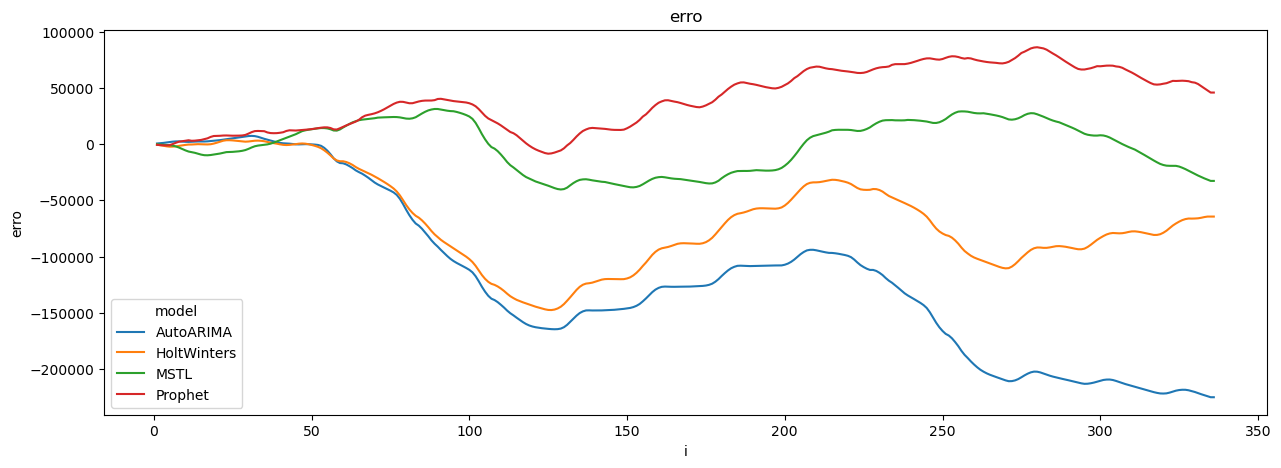

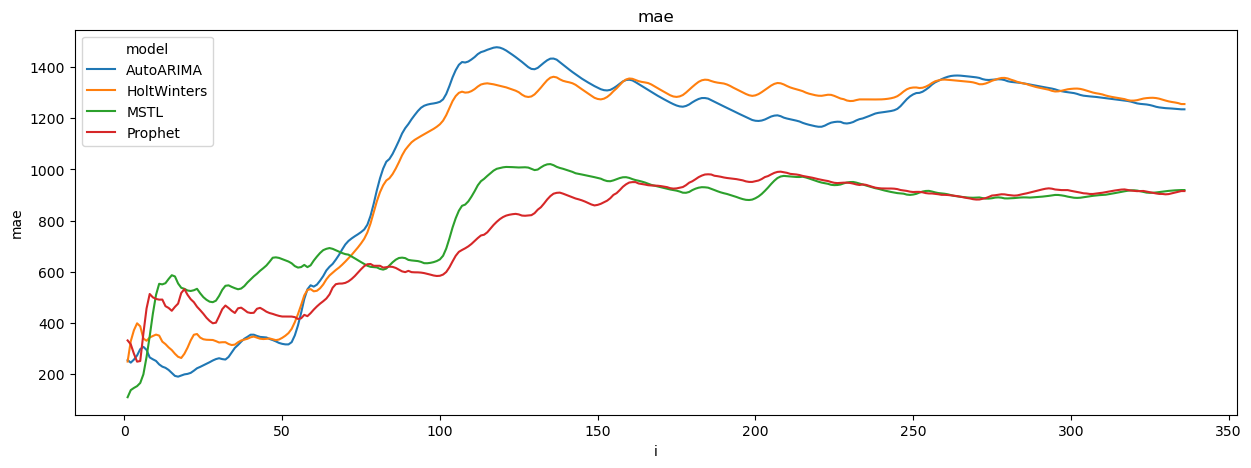

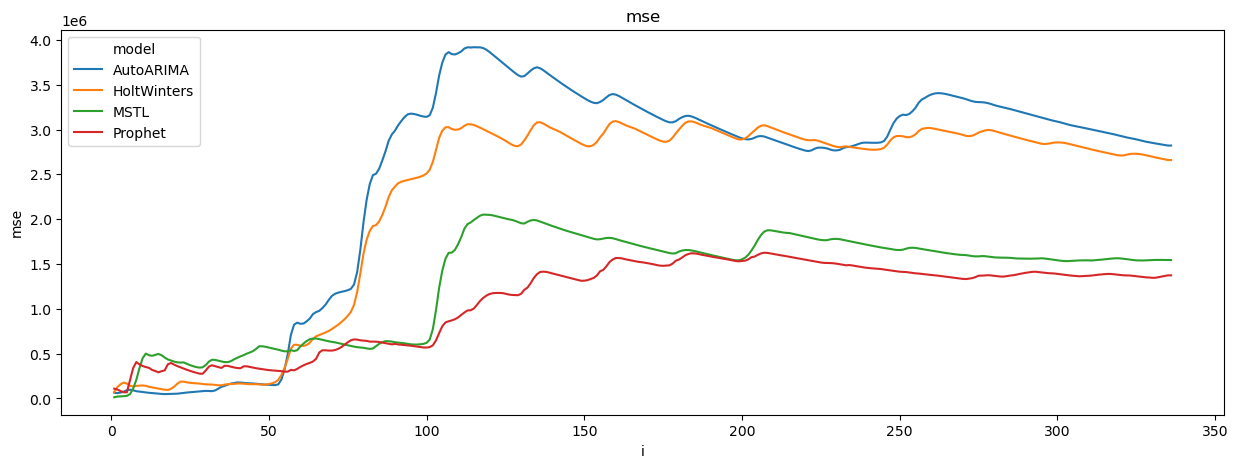

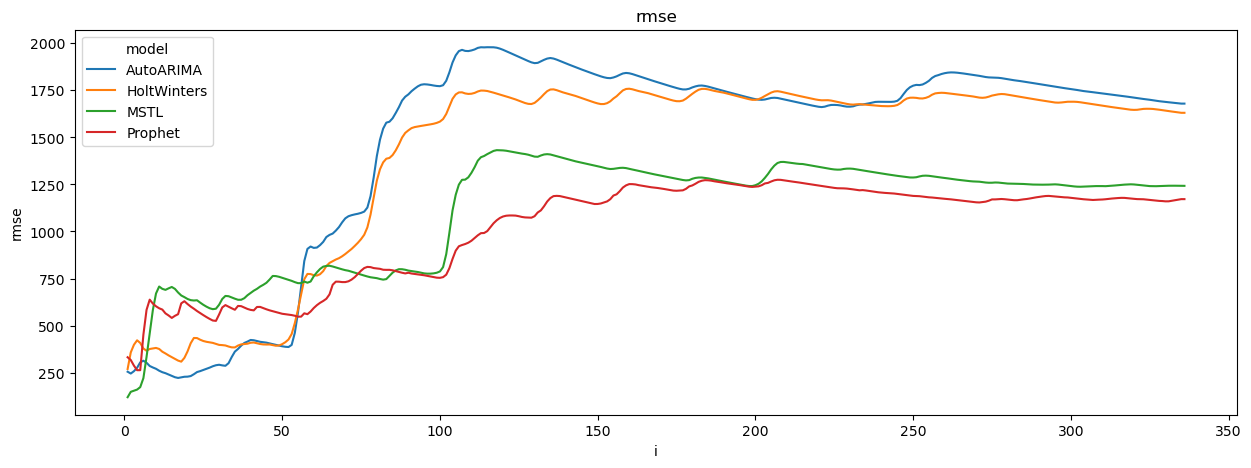

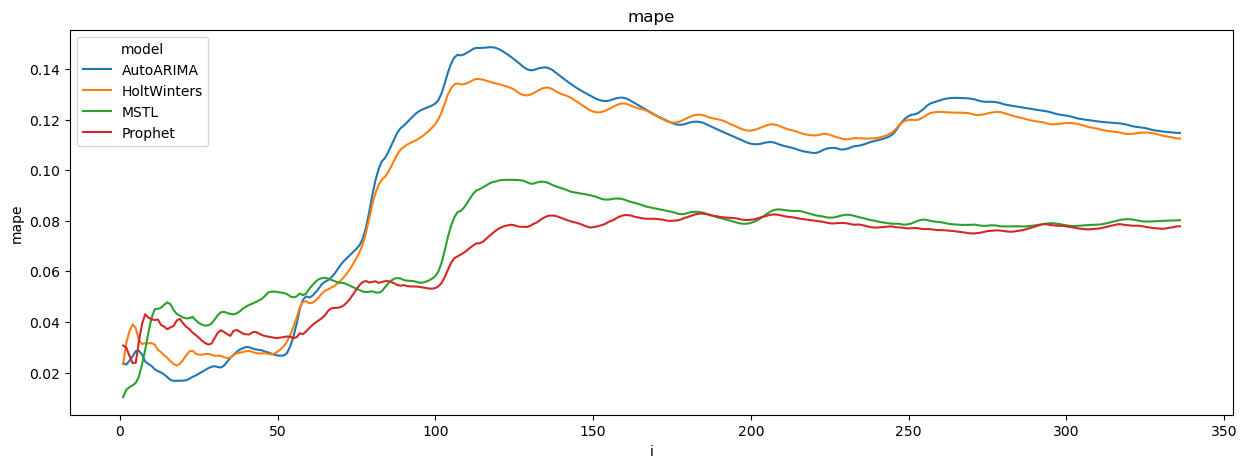

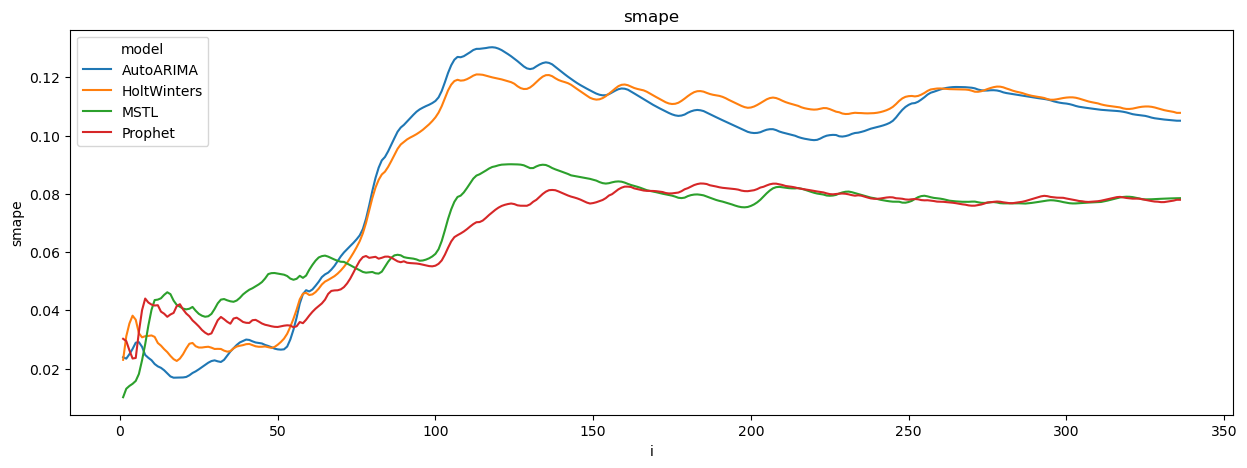

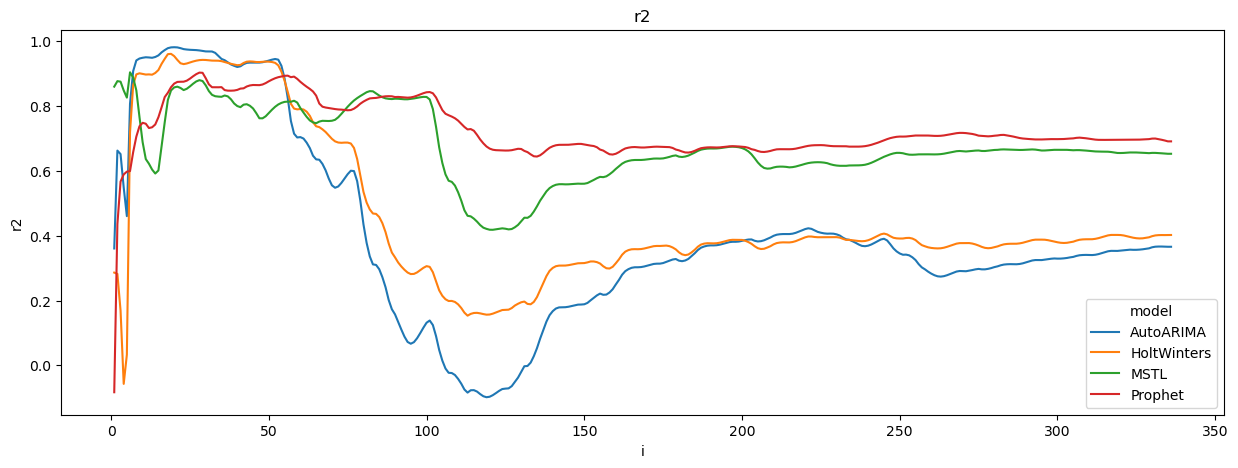

In [93]:
metrics = list(get_metrics(df_fc_test["yhat"], df_fc_test["y"]).keys())
for metric in metrics:
    plt.figure(figsize=(15,5))
    sns.lineplot(data=df_final, y=metric, x="i", hue="model")
    plt.title(metric)
    plt.show()

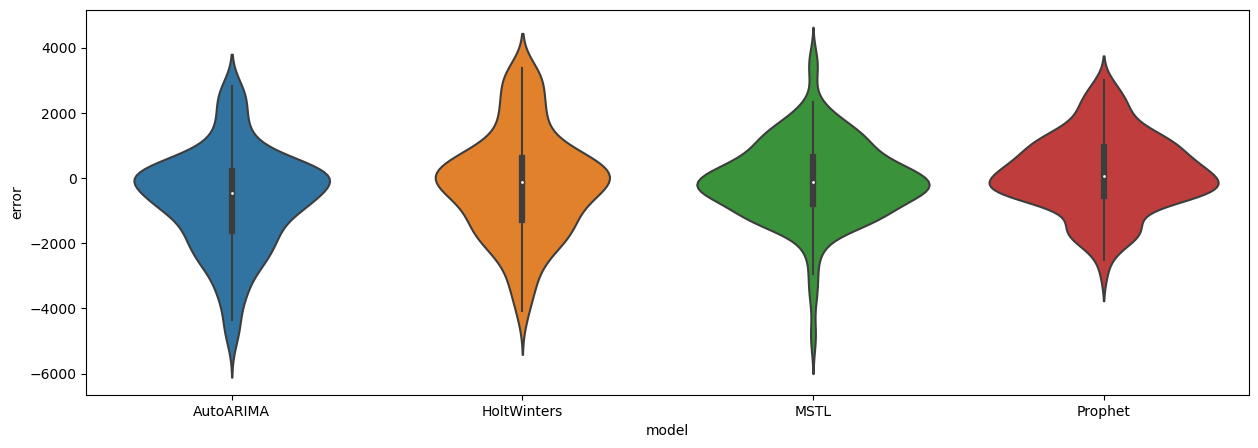

In [102]:
plt.figure(figsize=(15,5))
sns.violinplot(data=df_fc_test, x="model", y="error")
plt.show()